In [87]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score, root_mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.pso import PSO

from pymoo.optimize import minimize

import optuna

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os 
import warnings
warnings.filterwarnings("ignore")

from utils import *
from heuristics import *

DATA_PATH = f"{os.getcwd()}/data"

df_heating = pd.read_excel(f"{DATA_PATH}/Heating_degree_days_by_census_division.xls", skiprows=10)
df_cooling = pd.read_excel(f"{DATA_PATH}/Cooling_degree_days_by_census_division.xls", skiprows=10)
df_consumption = pd.read_excel(f"{DATA_PATH}/Residential_sector_energy_consumption.xls", skiprows=10)
df_average_prices = pd.read_excel(f"{DATA_PATH}/Average_prices_of_electricity_to_ultimate_customers.xls", skiprows=10)

df_consumption = df_consumption[["Month", "Total Energy Consumed by the Residential Sector"]]
df_average_prices = df_average_prices[["Month", "Average Price of Electricity to Ultimate Customers, Total", "Average Price of Electricity to Ultimate Customers, Residential"]]

merged_df = pd.merge(df_heating, df_cooling, on='Month', how='inner')
merged_df = pd.merge(merged_df, df_consumption, on='Month', how='inner')
merged_df = pd.merge(merged_df, df_average_prices, on='Month', how='inner')
merged_df = merged_df.drop(0)
df_cleaned = merged_df[~merged_df.isin(['Not Available']).any(axis=1)]
df_cleaned = df_cleaned.drop(columns=["Month"])

X, y = df_cleaned.drop(columns=["Total Energy Consumed by the Residential Sector"]), df_cleaned["Total Energy Consumed by the Residential Sector"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scoring = "neg_root_mean_squared_error"
pop_size = 10
crossover_rate = 0.8
mutation_rate = 0.5
n_generations = 10
n_exec = 10

# 0.5 e 0.5 é ruim
# 0.8 e 0.5 rodou rápido e deu um resultado satisfatório -- 129
# 0.8 e 0.7 demorou a rodar mas deu um bom resultado -- 136

In [88]:
def run_de_pymoo():
    problem = HyperparameterOptimizationProblem(X, y, scoring)
    de = DE(
        pop_size=pop_size,
        variant="DE/best/1/bin",
        CR=crossover_rate,
        F=mutation_rate,
        jitter=False,
        dither="vector",
    )
    res = minimize(
        problem,
        de,
        ("n_gen", n_generations),
        callback=PymooCallback()  # Use the custom callback to track best individuals
    )
    
    print(f"Best PYMOO DE: {res.F}")
    return res

def run_ga_pymoo():
    problem = HyperparameterOptimizationProblem(X, y, scoring)
    ga = GA(
    pop_size=pop_size,
    eliminate_duplicates=True,  # Ensure unique individuals in the population
    crossover_prob=crossover_rate,
    mutation_prob=mutation_rate,
    )
    res = minimize(
        problem,
        ga,
        ("n_gen", n_generations),
        callback=PymooCallback()  # Use the custom callback to track best individuals
    )
    
    print(f"Best PYMOO GA: {res.F}")
    return res


def run_pso_pymoo():
    problem = HyperparameterOptimizationProblem(X, y, scoring)
    pso = PSO(
        pop_size=pop_size,
        w=0.5,  # Inertia weight
        c1=0.5,  # Cognitive coefficient
        c2=0.3,  # Social coefficient
    )
    res = minimize(
        problem,
        pso,
        ("n_gen", n_generations),
        callback=PymooCallback()  # Use the custom callback to track best individuals
    )
    
    print(f"Best PYMOO PSO: {res.F}")
    return res

def run_optuna():
    optuna_mlp = OptunaMLP(X, y, scoring, n_trials=n_generations)
    best_trial = optuna_mlp.run()
    
    print(f"Best Optuna: {best_trial.value}")
    return optuna_mlp


def run_ga():
    ga = GeneticAlgorithm(
        pop_size=pop_size,
        crossover_rate=crossover_rate,
        mutation_rate=mutation_rate,
        n_generations=n_generations,
        scoring=scoring
    )

    ga.run(
        X,
        y,
    )
    
    print(f"Best GA: {ga.best_score}")
    return ga
    

def run_de():
    de = DifferentialEvolution(
        pop_size=pop_size,
        crossover_rate=crossover_rate,
        mutation_rate=mutation_rate,
        n_generations=n_generations,
        scoring=scoring,
    )

    de.run(
        X,
        y,
    )
    
    print(f"Best DE: {de.best_score}")
    return de

In [89]:
mean_vectors = dict(
    GA=np.zeros(n_generations),
    DE=np.zeros(n_generations),
    PSO=np.zeros(n_generations),
    Optuna=np.zeros(n_generations),
)
algorithms = dict(
    Optuna=run_optuna,
    GA=run_ga_pymoo,
    DE=run_de_pymoo,
    PSO=run_pso_pymoo,
)
results = dict()

for algorithm in algorithms:
    func = algorithms[algorithm]
    M = np.zeros((n_generations, n_exec))
    
    for idx in range(n_exec):
        if algorithm == "Optuna":
            optuna_result = func()
            M[:, idx] = optuna_result.best_individuals
        else:
            M[:, idx] = func().algorithm.callback.data["best_individuals"]
        
    mean_vector = np.zeros(n_generations)
    for idx in range(n_generations):
        mean_vector[idx] = np.mean(M[idx, :])
    
    results[algorithm] = mean_vector

Best Optuna: 182.84599770746723
Best Optuna: 166.2822676879507
Best Optuna: 183.12962893105617
Best Optuna: 185.55947496853113
Best Optuna: 173.77020687324426
Best Optuna: 170.58561547357334
Best Optuna: 162.91308124822535
Best Optuna: 167.6196505128922
Best Optuna: 163.01505984628358
Best Optuna: 168.65923921227903
Best PYMOO GA: [151.94737448]
Best PYMOO GA: [148.51134589]
Best PYMOO GA: [161.52410577]
Best PYMOO GA: [135.15327377]
Best PYMOO GA: [159.32792799]
Best PYMOO GA: [175.11197982]
Best PYMOO GA: [155.06784517]
Best PYMOO GA: [154.54155618]
Best PYMOO GA: [168.52975895]
Best PYMOO GA: [158.57997204]
Best PYMOO DE: [174.80492246]
Best PYMOO DE: [165.19182085]
Best PYMOO DE: [154.30187269]
Best PYMOO DE: [157.16273949]
Best PYMOO DE: [146.15636202]
Best PYMOO DE: [155.90865304]
Best PYMOO DE: [153.26581916]
Best PYMOO DE: [149.35826422]
Best PYMOO DE: [153.80999142]
Best PYMOO DE: [161.60460788]
Best PYMOO PSO: [136.9401255]
Best PYMOO PSO: [163.54231895]
Best PYMOO PSO: [171.

In [90]:
def plot_results(results, show_optuna, log_scale):
    domain = list(range(1, n_generations + 1))
    box_plot = dict()
    
    for algorithm, mean_vector in results.items():
        if algorithm == "Optuna" and not show_optuna:
            continue
        box_plot[algorithm] = mean_vector[n_generations-3:n_generations]
        plt.plot(domain, mean_vector, label=algorithm)
        if log_scale:
            plt.yscale("log")
    
    plt.xlabel("Gerações")
    plt.ylabel(f"Erro {scoring}")
    plt.xticks(domain)
    plt.legend()
    plt.title(f"Curva de convergência média - {n_exec} execuções")
    plt.show()
    
    keys = list(box_plot.keys())
    values = []
    for key in keys:
        values.append(box_plot[key])
        
    plt.boxplot(values, labels=keys)
    if log_scale:
        plt.yscale("log")
          
    plt.legend()
    plt.title(f"Boxplot - {n_exec} execuções")
    plt.ylabel(f"Erro {scoring}")
    plt.show()

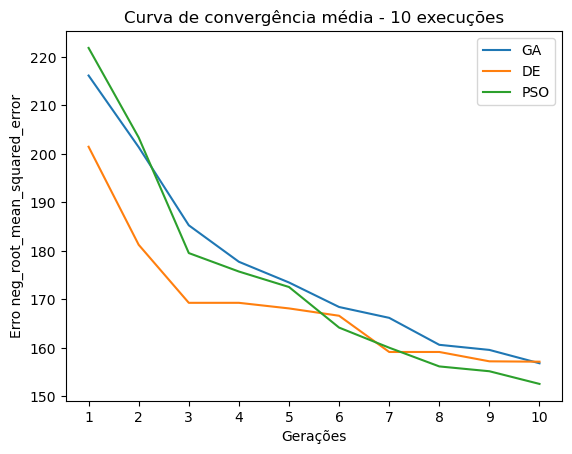

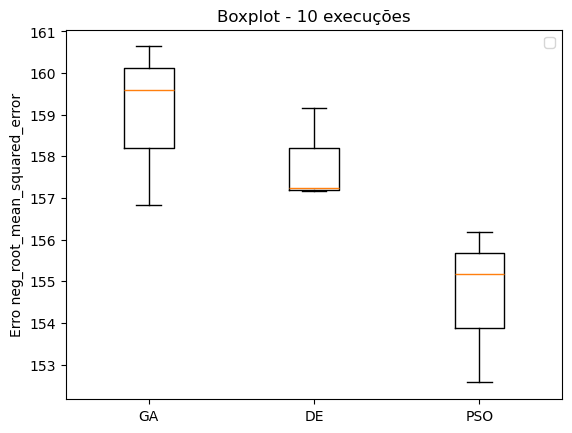

In [91]:
plot_results(results, show_optuna=False, log_scale=False)

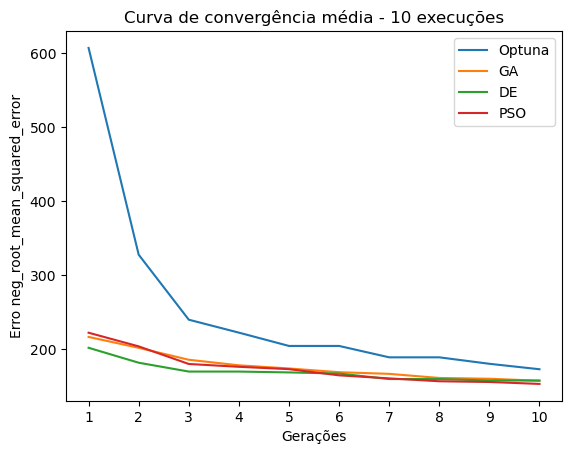

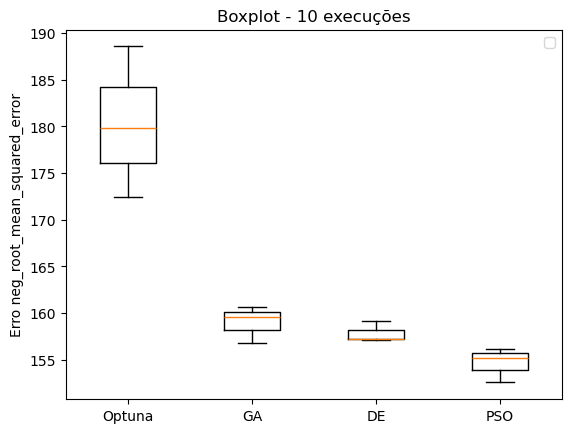

In [92]:
plot_results(results, show_optuna=True, log_scale=False)

In [93]:
res = run_ga_pymoo()
res.algorithm.callback.data["best_individuals"]

Best PYMOO GA: [146.08595353]


[np.float64(177.6647784202017),
 np.float64(177.6647784202017),
 np.float64(146.0859536412063),
 np.float64(146.0859536412063),
 np.float64(146.0859536412063),
 np.float64(146.0859536412063),
 np.float64(146.0859536412063),
 np.float64(146.0859536412063),
 np.float64(146.0859536412063),
 np.float64(146.0859535327234)]

In [94]:
res = run_de_pymoo()
res.algorithm.callback.data["best_individuals"]

Best PYMOO DE: [159.48027017]


[np.float64(205.90878465904584),
 np.float64(205.90878465904584),
 np.float64(205.90878465904584),
 np.float64(205.90878465904584),
 np.float64(205.90878465904584),
 np.float64(181.48731417987477),
 np.float64(181.48731417987477),
 np.float64(181.48731417987477),
 np.float64(159.48027016804923),
 np.float64(159.48027016804923)]

In [95]:
res = run_pso_pymoo()
res.algorithm.callback.data["best_individuals"]

Best PYMOO PSO: [160.72463642]


[np.float64(197.64731149298902),
 np.float64(197.64731149298902),
 np.float64(197.64731149298902),
 np.float64(173.72553014017905),
 np.float64(173.72553014017905),
 np.float64(173.72553014017905),
 np.float64(173.72553014017905),
 np.float64(160.72463642447534),
 np.float64(160.72463642447534),
 np.float64(160.72463642447534)]

In [96]:
run_optuna()

Best Optuna: 176.99885015420105


In [97]:
#run_ga()

In [98]:
#run_de()

In [99]:
mlp = best #MLPRegressor(hidden_layer_sizes=(20, 15, 10), max_iter=200)
metrics = ["r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"]

scores_mlp = train_with_cross_val(mlp, X, y, metrics)
#mlp.fit(X_train, y_train)

for metric, scores in scores_mlp.items():
    print(f"{metric}: {scores.mean():.4f} ± {scores.std():.4f}")

NameError: name 'best' is not defined